# Meteostat vs. MeteoCH

In [148]:
# ‘Soft’ reset: Only clears your namespace, leaving history intact.
%reset -sf
#[Howto: Indexing DataFrames in Pandas](https://www.dataquest.io/blog/tutorial-indexing-dataframes-in-pandas/)

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from meteostat import Stations
from meteostat import Daily
from IPython.display import Markdown as md

## Weather stations at MeteoCH

In [150]:
url = 'https://data.geo.admin.ch'
path = 'ch.meteoschweiz.klima/nbcn-tageswerte'
wsurl = url + '/' + path + '/' + 'liste-download-nbcn-d.csv'
ws = pd.read_csv(wsurl, sep=";", header=0, encoding = "ISO-8859-1").dropna()
pd.options.display.float_format = '{:.2f}'.format
ws.rename(columns={'Station height m. a. sea level': 'elevation'}, inplace=True)
ws.drop(['WIGOS-ID', 'CoordinatesE', 'CoordinatesN', 'URL Previous years (verified data)', 
         'URL Current year', 'station/location', 'Canton', 'Climate region'], axis=1)

,Station,Data since,elevation,Latitude,Longitude
0,Altdorf,01.01.1864,438.00,46.89,8.62
1,Andermatt,01.01.1864,1438.00,46.63,8.58
2,Basel / Binningen,01.01.1755,316.00,47.54,7.58
3,Bern / Zollikofen,01.01.1864,553.00,46.99,7.46
4,La Chaux-de-Fonds,01.01.1900,1017.00,47.08,6.79
5,Château-d'Oex,01.01.1879,1028.00,46.48,7.14
6,Chaumont,01.01.1864,1136.00,47.05,6.98
7,Davos,01.01.1864,1594.00,46.81,9.84
8,Elm,01.02.1878,958.00,46.92,9.18
9,Engelberg,01.01.1864,1036.00,46.82,8.41


In [151]:
# Cell tagged w/ parameters
#
# Calling syntax:
# papermill Meteostat_vs_MeteoCH.ipynb foo.ipynb [-p wsno 42 -p sd 1 -p sm 2 -p sy 2022]
sd = 15
sm = 10
sy = 2023
ed = 25
em = 10
ey = 2023

wsno = -1 # select index number from above table

In [152]:
# Compute start and end of period of interest
start = datetime(sy, sm, sd)
end = datetime(ey, em, ed)

# Extracdt station name
wstation = ws.iloc[wsno]['Station']
df = ws[ws.Station==wstation]
label = df.iloc[0]['station/location'] #.to_string()[::-1][0:3][::-1]
lat = df.iloc[0]['Latitude']
lon = df.iloc[0]['Longitude']
md(f"## Compare data of weather station {wstation} w/ label {label} located at ({lat:.2f}/{lon:.2f}).")

## Compare data of weather station St. Gallen w/ label STG located at (47.43/9.40).

In [153]:
md("## Observations at MeteoCH for %s"%(wstation))

## Observations at MeteoCH for St. Gallen

In [154]:
filenm = "nbcn-daily_"
ext="csv"
# Create urls using above selected label
currurl = url + "/" + path + "/" + filenm + label + "_current." + ext
prevurl = url + "/" + path + "/" + filenm + label + "_previous." + ext
cf = pd.read_csv(currurl, sep=";", index_col='date',converters={'date':pd.to_datetime}).drop(['station/location'], axis=1) #, engine='pyarrow')
for col in  cf.columns:
    cf[col] = pd.to_numeric(cf[col], errors='coerce')
pf = pd.read_csv(prevurl, sep=";", index_col='date',converters={'date':pd.to_datetime}).drop(['station/location'], axis=1) #, engine='pyarrow')
for col in  pf.columns:
    pf[col] = pd.to_numeric(pf[col], errors='coerce')
meteoch = pd.concat([pf, cf], axis=0)
daterange = (meteoch.index>=start)&(meteoch.index<=end)
meteoch = meteoch.loc[daterange]
print(meteoch.count())

gre000d0    13
hto000d0    13
nto000d0     0
prestad0    13
rre150d0    13
sre000d0    13
tre200d0    13
tre200dn    13
tre200dx    13
ure200d0    13
dtype: int64


In [155]:
# Rename columns in MeteoCH to allow comparison with Meteostat
meteoch.rename(columns={'sre000d0': 'tsun','prestad0': 'pres', 'hto000d0': 'snow', 'rre150d0': 'prcp', 
                  'tre200d0': 'tavg', 'tre200dn': 'tmin', 'tre200dx': 'tmax'}, inplace=True)

In [156]:
md("## Extract weather data from Meteostat using GPS coordinates of %s"%(wstation))

## Extract weather data from Meteostat using GPS coordinates of St. Gallen

In [157]:
stations = Stations()
ws = stations.nearby(lat, lon).fetch(3)
ws.drop(['region', 'icao', 'timezone' ,'hourly_start', 'hourly_end', 'daily_start', 'daily_end', 'monthly_start', 'monthly_end'], axis=1)

,name,country,wmo,latitude,longitude,elevation,distance
id,,,,,,,
06681,Saint Gallen,CH,06681,47.43,9.40,779.00,877.12
06690,Altenrhein-Flugplatz,CH,06690,47.48,9.38,398.00,6530.99
06678,Bischofszell / Sittertal,CH,06678,47.50,9.23,470.00,14691.10


## Observations at Meteostat

In [158]:
id = ws.index.values[0]
meteostat = Daily(id, start, end)
meteostat = meteostat.fetch()
print(meteostat.count())

tavg    13
tmin    13
tmax    13
prcp     0
snow     0
wdir    13
wspd    13
wpgt    13
pres    13
tsun     0
dtype: int64


## Differences

In [159]:
md("### Tabular comparison for %s"%(wstation))

### Tabular comparison for St. Gallen

In [160]:
common = meteoch.columns.intersection(meteostat.columns)
adiff = meteoch[common] - meteostat[common]
rdiff = adiff/meteoch[common]

#### Absolute difference

In [161]:
adiff.describe().map('{:.1f}'.format)

,snow,pres,prcp,tsun,tavg,tmin,tmax
count,0.0,13.0,0.0,0.0,13.0,13.0,13.0
mean,nan,-89.6,nan,nan,0.0,-0.7,1.5
std,nan,1.7,nan,nan,0.9,1.0,1.3
min,nan,-92.5,nan,nan,-1.4,-2.4,0.2
25%,nan,-91.0,nan,nan,-0.5,-1.1,0.6
50%,nan,-89.3,nan,nan,0.0,-0.7,1.1
75%,nan,-89.0,nan,nan,0.8,-0.4,1.6
max,nan,-86.1,nan,nan,1.2,1.0,4.5


#### Relative difference

In [162]:
rdiff.describe().map('{:.1%}'.format)

,snow,pres,prcp,tsun,tavg,tmin,tmax
count,0.0%,1300.0%,0.0%,0.0%,1300.0%,1300.0%,1300.0%
mean,nan%,-9.7%,nan%,nan%,-1.5%,-12.9%,8.4%
std,nan%,0.2%,nan%,nan%,7.7%,16.3%,6.5%
min,nan%,-10.0%,nan%,nan%,-14.5%,-47.4%,1.4%
25%,nan%,-9.8%,nan%,nan%,-9.8%,-19.0%,3.8%
50%,nan%,-9.6%,nan%,nan%,0.0%,-8.5%,7.0%
75%,nan%,-9.5%,nan%,nan%,4.3%,-3.4%,10.9%
max,nan%,-9.5%,nan%,nan%,8.8%,10.8%,22.7%


In [163]:
md("### Graphical comparison for %s"%(wstation))

### Graphical comparison for St. Gallen

In [164]:
plt.style.use('ggplot')
# print(plt.style.available)
fswidth = 10
fsheight = 5

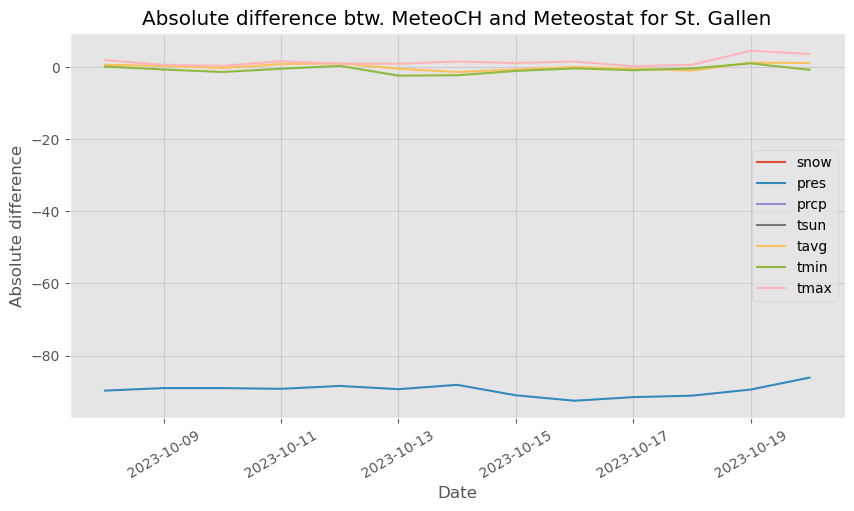

In [165]:
fig, axs = plt.subplots(figsize=(fswidth, fsheight))

axs.plot(adiff)
axs.grid(visible='visible', which='major', color='0.8', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Absolute difference')
plt.title(f'Absolute difference btw. MeteoCH and Meteostat for {wstation}')
plt.xticks(rotation=30)
plt.legend(adiff.columns, loc="center right")
plt.show()

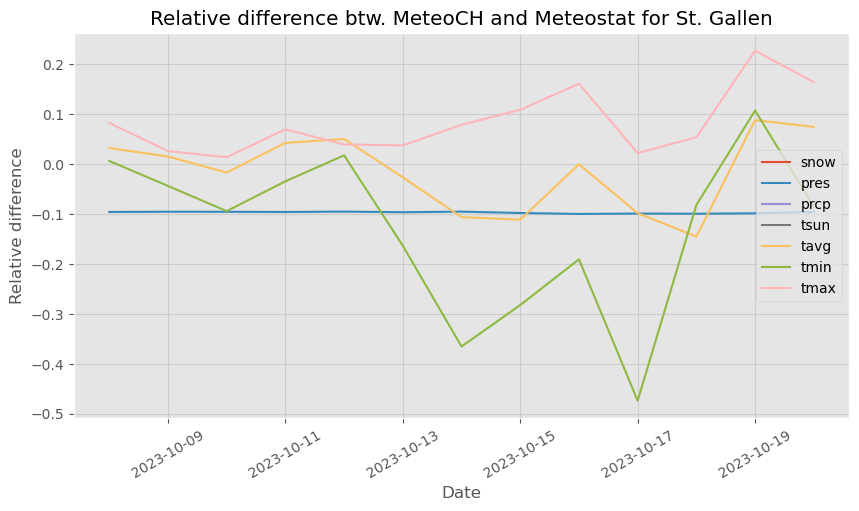

In [166]:
fig, axs = plt.subplots(figsize=(fswidth, fsheight))

axs.plot(rdiff)
axs.grid(visible='visible', which='major', color='0.8', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Relative difference')
plt.title(f'Relative difference btw. MeteoCH and Meteostat for {wstation}')
plt.xticks(rotation=30)
plt.legend(rdiff.columns, loc="center right")
plt.show()